In [1]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 98%|████████████████████████████████████████ | 552M/565M [00:02<00:00, 223MB/s]
100%|█████████████████████████████████████████| 565M/565M [00:02<00:00, 203MB/s]


In [2]:
# prompt: extract checkpoints.zip and results.zip

import zipfile
import os

data_file_path = "fashion-product-images-small.zip"

# Extract the contents to the current directory
with zipfile.ZipFile(data_file_path, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())  # Extract to current directory



In [3]:
!mkdir checkpoints
!mkdir results
!cp /kaggle/input/vae-checkpoints/*.pth ./checkpoints
!cp /kaggle/input/vae-results/*.csv ./results

In [4]:
!pip install torchsummary

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.io as io
import torchvision.transforms as T

import os

In [6]:
# params
RANDOM_STATE = 42
BATCH_SIZE = 64
EPOCHS = 50
LATENT_DIM=16
WIDTH = 64
HEIGHT = 64
LEARNING_RATE =1e-4
IN_CHANNELS = 3


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:

class FashionDataset(Dataset):

    def __init__(self):
        self.images = os.listdir('images')
        self.num_samples = len(self.images)

    def __len__(self):
        return self.num_samples


    def __getitem__(self, idx) -> torch.Tensor:
        img = io.read_image(f"images/{self.images[idx]}")
        if img.shape[0] == 1:
            img = img.repeat(3,1,1)
        transform = T.Resize((64,64))
        img = transform(img)


        return img



In [9]:

class VAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=32):
        super(VAE, self).__init__()

        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 30, 40)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 15, 20)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.ReLU(),
            nn.BatchNorm2d(128),

        )

        # Flattened size after the final Conv2d layer
        self.flattened_size = 128 * 8 * 8

        # Fully connected layers for latent space
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Fully connected layer for decoding
        self.fc_decode = nn.Linear(latent_dim, self.flattened_size)

        # Decoder: Transposed Convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 14, 20)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 32, 40)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),  # Output: (3, 60, 80),
            nn.ReLU()
        )


    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 128, 8, 8)  # Reshape for ConvTranspose2d
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar



In [10]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum')


    def forward(self, recon_x, x, mu, logvar):

        # Reconstruction loss
        recon_loss = self.reconstruction_loss(recon_x, x)

        # KL Divergence
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss = reconstruction loss + KL divergence
        total_loss = recon_loss + kl_divergence
        return total_loss


In [11]:
dataset = FashionDataset()
# prompt: split the dataset into train, test, validation datasets using random_split

# Define the split sizes (e.g., 80% train, 15% test, 5% val_size)
train_size = int(0.8 * len(dataset))
remaining = len(dataset)- train_size
test_size = int(0.9 * remaining)
val_size = remaining - test_size

print(train_size, test_size, val_size)
# Split the dataset
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create DataLoaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

35552 8000 889


In [12]:

# Training loop
def train(train_no: int, model: nn.Module, criterion, optimizer, epochs: int):
  from tqdm import tqdm
  import pandas as pd

  results = []
  print(f"Train No: {train_no}")
  for epoch in range(1,epochs+1):
      model.train()
      running_loss = 0.0

      for batch_idx, input_images in tqdm(enumerate(train_loader), desc=f"Training: Epoch {epoch}/{EPOCHS}"):
          # Zero the parameter gradients
          optimizer.zero_grad()


          input_images = input_images.type(torch.float)
          input_images = input_images.to(device)
          # Forward pass
          recons, mu, logvar = model(input_images)
          loss = criterion(recons, input_images, mu, logvar)  # Reconstruction loss

          # # Backward pass and optimize
          loss.backward()
          optimizer.step()

          # # Track loss
          running_loss += loss.item()

      train_loss = running_loss / len(train_loader)



      model.eval()  # Set the model to evaluation mode (important for layers like dropout, batchnorm)

      test_loss = 0.0

      with torch.no_grad():  # Disable gradient calculations (saves memory and computations during testing)
          for batch_idx, input_images in tqdm(enumerate(test_loader),  desc=f"Testing: Epoch {epoch}/{EPOCHS}"):

              input_images = input_images.type(torch.float)
              input_images = input_images.to(device)
              # Forward pass
              outputs, mu, logvar = model(input_images)

              # Calculate loss
              loss = criterion(outputs, input_images, mu, logvar)
              test_loss += loss.item()

      # Print average loss for the epoch
      test_loss = test_loss / len(test_loader)

      print(f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

      if train_loss == torch.nan or test_loss == torch.nan:
        print("Train Loss or Test Loss is nan")
        break

      if train_loss == float('inf') or test_loss == float('inf'):
        print("Train Loss or Test Loss is inf")
        break

      if epoch % 10 == 0:
        torch.save(model.state_dict(), f'checkpoints/vae_model_train_{train_no}_epoch_{epoch}.pth')
        results_df = pd.DataFrame(results)

        # train_loss_arr = get_last_10_items(results_df['train_loss'].to_numpy())
        # test_loss_arr = get_last_10_items(results_df['test_loss'].to_numpy())
        # if not analyze_loss_trend(train_loss_arr) or not analyze_loss_trend(test_loss_arr):
        #   print("trend is not stable")
        #   break
        results_df.to_csv(f"results/results_train_{train_no}.csv", index=False)


      results.append({
            "train_no": train_no,
             "epoch_no": epoch,
             "train_loss": train_loss,
             "test_loss": test_loss
      })



  print(f"Train No: {train_no} - Training completed")


In [15]:
LEARNING_RATE = 1e-4
EPOCHS = 100
TRAIN_NO = 22
model = VAE(in_channels=IN_CHANNELS, latent_dim=LATENT_DIM).to(device=device)
model.load_state_dict(torch.load(f'checkpoints/vae_model_train_{TRAIN_NO-1}_epoch_{EPOCHS}.pth', weights_only=False))
criterion = VAELoss().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [14]:
from torchsummary import summary
summary(model, input_size=(IN_CHANNELS, WIDTH, HEIGHT))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,568
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 16, 16]          32,832
              ReLU-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7            [-1, 128, 8, 8]         131,200
              ReLU-8            [-1, 128, 8, 8]               0
       BatchNorm2d-9            [-1, 128, 8, 8]             256
           Linear-10                   [-1, 16]         131,088
           Linear-11                   [-1, 16]         131,088
           Linear-12                 [-1, 8192]         139,264
  ConvTranspose2d-13           [-1, 64, 16, 16]         131,136
             ReLU-14           [-1, 64,

In [15]:
train(TRAIN_NO, model, criterion, optimizer, EPOCHS)

Train No: 28


Training: Epoch 1/100: 556it [00:26, 21.30it/s]
Testing: Epoch 1/100: 125it [00:04, 27.67it/s]


Train Loss: 315980029.6978, Test Loss: 314909671.1680


Training: Epoch 2/100: 556it [00:25, 21.79it/s]
Testing: Epoch 2/100: 125it [00:04, 27.08it/s]


Train Loss: 313837806.1583, Test Loss: 313844028.2880


Training: Epoch 3/100: 556it [00:25, 22.09it/s]
Testing: Epoch 3/100: 125it [00:04, 27.63it/s]


Train Loss: 313586148.3453, Test Loss: 317298408.8320


Training: Epoch 4/100: 556it [00:25, 22.18it/s]
Testing: Epoch 4/100: 125it [00:04, 28.10it/s]


Train Loss: 312980075.1799, Test Loss: 315451995.0080


Training: Epoch 5/100: 556it [00:24, 22.55it/s]
Testing: Epoch 5/100: 125it [00:04, 28.12it/s]


Train Loss: 312491446.9353, Test Loss: 316906509.1840


Training: Epoch 6/100: 556it [00:24, 22.30it/s]
Testing: Epoch 6/100: 125it [00:04, 27.79it/s]


Train Loss: 312253615.9424, Test Loss: 317484990.7200


Training: Epoch 7/100: 556it [00:24, 22.58it/s]
Testing: Epoch 7/100: 125it [00:04, 27.89it/s]


Train Loss: 312177637.6115, Test Loss: 317606034.8160


Training: Epoch 8/100: 556it [00:24, 22.42it/s]
Testing: Epoch 8/100: 125it [00:04, 28.75it/s]


Train Loss: 311899608.2878, Test Loss: 318526849.1520


Training: Epoch 9/100: 556it [00:24, 22.33it/s]
Testing: Epoch 9/100: 125it [00:04, 28.46it/s]


Train Loss: 311782857.9424, Test Loss: 317672316.1600


Training: Epoch 10/100: 556it [00:24, 22.56it/s]
Testing: Epoch 10/100: 125it [00:04, 26.42it/s]


Train Loss: 311647649.4101, Test Loss: 318947653.3760


Training: Epoch 11/100: 556it [00:24, 22.61it/s]
Testing: Epoch 11/100: 125it [00:04, 27.89it/s]


Train Loss: 311244692.6043, Test Loss: 322246085.6320


Training: Epoch 12/100: 556it [00:24, 22.69it/s]
Testing: Epoch 12/100: 125it [00:04, 28.69it/s]


Train Loss: 311018540.6906, Test Loss: 320989654.1440


Training: Epoch 13/100: 556it [00:24, 22.62it/s]
Testing: Epoch 13/100: 125it [00:04, 28.39it/s]


Train Loss: 310988867.5396, Test Loss: 319515223.0400


Training: Epoch 14/100: 556it [00:24, 22.64it/s]
Testing: Epoch 14/100: 125it [00:04, 28.98it/s]


Train Loss: 310854086.1295, Test Loss: 319919397.8880


Training: Epoch 15/100: 556it [00:24, 23.04it/s]
Testing: Epoch 15/100: 125it [00:04, 28.78it/s]


Train Loss: 310642174.1583, Test Loss: 320348083.3280


Training: Epoch 16/100: 556it [00:24, 22.74it/s]
Testing: Epoch 16/100: 125it [00:04, 28.43it/s]


Train Loss: 310756763.2518, Test Loss: 321755938.8160


Training: Epoch 17/100: 556it [00:24, 23.01it/s]
Testing: Epoch 17/100: 125it [00:04, 28.55it/s]


Train Loss: 310528618.2734, Test Loss: 320428057.8560


Training: Epoch 18/100: 556it [00:24, 22.63it/s]
Testing: Epoch 18/100: 125it [00:04, 29.24it/s]


Train Loss: 310362556.2014, Test Loss: 320823974.1440


Training: Epoch 19/100: 556it [00:24, 22.57it/s]
Testing: Epoch 19/100: 125it [00:04, 28.85it/s]


Train Loss: 310386437.5827, Test Loss: 321649512.5760


Training: Epoch 20/100: 556it [00:24, 22.74it/s]
Testing: Epoch 20/100: 125it [00:04, 27.66it/s]


Train Loss: 310140949.7266, Test Loss: 321442136.5760


Training: Epoch 21/100: 556it [00:24, 22.65it/s]
Testing: Epoch 21/100: 125it [00:04, 28.31it/s]


Train Loss: 310092249.4101, Test Loss: 322371984.3840


Training: Epoch 22/100: 556it [00:24, 22.88it/s]
Testing: Epoch 22/100: 125it [00:04, 28.77it/s]


Train Loss: 310057362.4460, Test Loss: 321942166.1440


Training: Epoch 23/100: 556it [00:24, 22.60it/s]
Testing: Epoch 23/100: 125it [00:04, 28.88it/s]


Train Loss: 309797719.7986, Test Loss: 323495262.7200


Training: Epoch 24/100: 556it [00:24, 22.80it/s]
Testing: Epoch 24/100: 125it [00:04, 28.39it/s]


Train Loss: 309953991.7986, Test Loss: 323696789.7600


Training: Epoch 25/100: 556it [00:24, 22.28it/s]
Testing: Epoch 25/100: 125it [00:04, 28.21it/s]


Train Loss: 309936502.1583, Test Loss: 322629577.6000


Training: Epoch 26/100: 556it [00:24, 22.53it/s]
Testing: Epoch 26/100: 125it [00:04, 28.31it/s]


Train Loss: 309900444.3453, Test Loss: 325458391.9360


Training: Epoch 27/100: 556it [00:24, 22.74it/s]
Testing: Epoch 27/100: 125it [00:04, 28.64it/s]


Train Loss: 309871019.1367, Test Loss: 323371496.9600


Training: Epoch 28/100: 556it [00:24, 22.36it/s]
Testing: Epoch 28/100: 125it [00:04, 28.07it/s]


Train Loss: 309506147.2518, Test Loss: 323669257.8560


Training: Epoch 29/100: 556it [00:24, 22.34it/s]
Testing: Epoch 29/100: 125it [00:04, 27.89it/s]


Train Loss: 309371306.4029, Test Loss: 323576267.3920


Training: Epoch 30/100: 556it [00:25, 22.15it/s]
Testing: Epoch 30/100: 125it [00:04, 27.86it/s]


Train Loss: 309301317.8417, Test Loss: 324325469.5680


Training: Epoch 31/100: 556it [00:25, 22.12it/s]
Testing: Epoch 31/100: 125it [00:04, 27.91it/s]


Train Loss: 309435165.2374, Test Loss: 322836705.4080


Training: Epoch 32/100: 556it [00:24, 22.57it/s]
Testing: Epoch 32/100: 125it [00:04, 28.22it/s]


Train Loss: 309256409.3813, Test Loss: 323376855.6800


Training: Epoch 33/100: 556it [00:24, 22.65it/s]
Testing: Epoch 33/100: 125it [00:04, 27.17it/s]


Train Loss: 309583842.5612, Test Loss: 324551567.8720


Training: Epoch 34/100: 556it [00:24, 22.70it/s]
Testing: Epoch 34/100: 125it [00:04, 28.10it/s]


Train Loss: 309054500.9496, Test Loss: 326624363.7760


Training: Epoch 35/100: 556it [00:24, 22.35it/s]
Testing: Epoch 35/100: 125it [00:04, 27.93it/s]


Train Loss: 308870531.9424, Test Loss: 324320091.3920


Training: Epoch 36/100: 556it [00:25, 22.05it/s]
Testing: Epoch 36/100: 125it [00:04, 28.25it/s]


Train Loss: 309345213.2662, Test Loss: 324086789.3760


Training: Epoch 37/100: 556it [00:25, 22.18it/s]
Testing: Epoch 37/100: 125it [00:04, 28.32it/s]


Train Loss: 308973133.2086, Test Loss: 324895060.3520


Training: Epoch 38/100: 556it [00:24, 22.31it/s]
Testing: Epoch 38/100: 125it [00:04, 28.30it/s]


Train Loss: 309285239.5971, Test Loss: 326870987.5200


Training: Epoch 39/100: 556it [00:24, 22.40it/s]
Testing: Epoch 39/100: 125it [00:04, 27.96it/s]


Train Loss: 321022446.9353, Test Loss: 327707259.6480


Training: Epoch 40/100: 556it [00:24, 22.50it/s]
Testing: Epoch 40/100: 125it [00:04, 27.82it/s]


Train Loss: 310743213.7842, Test Loss: 325379556.0960


Training: Epoch 41/100: 556it [00:25, 22.14it/s]
Testing: Epoch 41/100: 125it [00:04, 28.11it/s]


Train Loss: 308922583.1655, Test Loss: 325486721.9200


Training: Epoch 42/100: 556it [00:25, 22.18it/s]
Testing: Epoch 42/100: 125it [00:04, 28.15it/s]


Train Loss: 308553084.7770, Test Loss: 325229983.4880


Training: Epoch 43/100: 556it [00:25, 22.19it/s]
Testing: Epoch 43/100: 125it [00:04, 28.28it/s]


Train Loss: 308605879.6835, Test Loss: 324604486.4000


Training: Epoch 44/100: 556it [00:25, 22.05it/s]
Testing: Epoch 44/100: 125it [00:04, 27.26it/s]


Train Loss: 308396478.9353, Test Loss: 325253366.4000


Training: Epoch 45/100: 556it [00:24, 22.57it/s]
Testing: Epoch 45/100: 125it [00:04, 27.77it/s]


Train Loss: 308415686.6763, Test Loss: 325970872.1920


Training: Epoch 46/100: 556it [00:24, 22.64it/s]
Testing: Epoch 46/100: 125it [00:04, 26.86it/s]


Train Loss: 308615698.6475, Test Loss: 326461226.2400


Training: Epoch 47/100: 556it [00:24, 22.59it/s]
Testing: Epoch 47/100: 125it [00:04, 28.06it/s]


Train Loss: 308500201.1511, Test Loss: 327045976.0640


Training: Epoch 48/100: 556it [00:24, 22.60it/s]
Testing: Epoch 48/100: 125it [00:04, 29.11it/s]


Train Loss: 308522607.4532, Test Loss: 328819134.7200


Training: Epoch 49/100: 556it [00:24, 22.72it/s]
Testing: Epoch 49/100: 125it [00:04, 29.02it/s]


Train Loss: 308510359.9424, Test Loss: 326562818.6880


Training: Epoch 50/100: 556it [00:24, 22.75it/s]
Testing: Epoch 50/100: 125it [00:04, 27.87it/s]


Train Loss: 308484244.1727, Test Loss: 328556170.7520


Training: Epoch 51/100: 556it [00:24, 22.54it/s]
Testing: Epoch 51/100: 125it [00:04, 28.53it/s]


Train Loss: 308481888.5755, Test Loss: 327127666.9440


Training: Epoch 52/100: 556it [00:25, 22.21it/s]
Testing: Epoch 52/100: 125it [00:04, 27.30it/s]


Train Loss: 308361196.5755, Test Loss: 326662552.7040


Training: Epoch 53/100: 556it [00:25, 22.07it/s]
Testing: Epoch 53/100: 125it [00:04, 27.57it/s]


Train Loss: 308282647.8561, Test Loss: 326551479.8080


Training: Epoch 54/100: 556it [00:24, 22.29it/s]
Testing: Epoch 54/100: 125it [00:04, 27.74it/s]


Train Loss: 308278469.4101, Test Loss: 330183615.4880


Training: Epoch 55/100: 556it [00:25, 22.02it/s]
Testing: Epoch 55/100: 125it [00:04, 28.07it/s]


Train Loss: 308215696.9209, Test Loss: 327357140.4800


Training: Epoch 56/100: 556it [00:25, 21.84it/s]
Testing: Epoch 56/100: 125it [00:04, 28.24it/s]


Train Loss: 308052093.2950, Test Loss: 327187362.6880


Training: Epoch 57/100: 556it [00:24, 22.39it/s]
Testing: Epoch 57/100: 125it [00:04, 28.25it/s]


Train Loss: 308062778.6187, Test Loss: 327980169.9840


Training: Epoch 58/100: 556it [00:25, 22.19it/s]
Testing: Epoch 58/100: 125it [00:04, 27.15it/s]


Train Loss: 308092765.8705, Test Loss: 330885975.8080


Training: Epoch 59/100: 556it [00:25, 22.14it/s]
Testing: Epoch 59/100: 125it [00:05, 24.69it/s]


Train Loss: 307929666.0432, Test Loss: 328046342.5280


Training: Epoch 60/100: 556it [00:25, 21.76it/s]
Testing: Epoch 60/100: 125it [00:04, 25.15it/s]


Train Loss: 308174732.1439, Test Loss: 327954086.9120


Training: Epoch 61/100: 556it [00:25, 21.71it/s]
Testing: Epoch 61/100: 125it [00:04, 25.96it/s]


Train Loss: 308008875.2806, Test Loss: 328603150.8480


Training: Epoch 62/100: 556it [00:25, 21.83it/s]
Testing: Epoch 62/100: 125it [00:04, 27.39it/s]


Train Loss: 307932979.3094, Test Loss: 329249267.2000


Training: Epoch 63/100: 556it [00:25, 21.63it/s]
Testing: Epoch 63/100: 125it [00:04, 27.91it/s]


Train Loss: 307900708.8201, Test Loss: 327356636.9280


Training: Epoch 64/100: 556it [00:24, 22.39it/s]
Testing: Epoch 64/100: 125it [00:04, 27.65it/s]


Train Loss: 307614868.8345, Test Loss: 329031551.4880


Training: Epoch 65/100: 556it [00:25, 22.14it/s]
Testing: Epoch 65/100: 125it [00:04, 27.69it/s]


Train Loss: 307934645.2374, Test Loss: 331730137.0880


Training: Epoch 66/100: 556it [00:25, 21.88it/s]
Testing: Epoch 66/100: 125it [00:04, 27.18it/s]


Train Loss: 307861250.1871, Test Loss: 328678868.4800


Training: Epoch 67/100: 556it [00:25, 21.76it/s]
Testing: Epoch 67/100: 125it [00:04, 27.91it/s]


Train Loss: 307676292.8633, Test Loss: 328735428.6080


Training: Epoch 68/100: 556it [00:24, 22.53it/s]
Testing: Epoch 68/100: 125it [00:04, 28.42it/s]


Train Loss: 307798920.6331, Test Loss: 328297513.4720


Training: Epoch 69/100: 556it [00:25, 22.17it/s]
Testing: Epoch 69/100: 125it [00:04, 27.96it/s]


Train Loss: 307702239.3381, Test Loss: 329444950.5280


Training: Epoch 70/100: 556it [00:25, 22.14it/s]
Testing: Epoch 70/100: 125it [00:04, 28.42it/s]


Train Loss: 307616969.0072, Test Loss: 328398793.7280


Training: Epoch 71/100: 556it [00:24, 22.28it/s]
Testing: Epoch 71/100: 125it [00:04, 27.53it/s]


Train Loss: 307644636.4029, Test Loss: 328760275.7120


Training: Epoch 72/100: 556it [00:25, 21.97it/s]
Testing: Epoch 72/100: 125it [00:04, 28.29it/s]


Train Loss: 307609604.1151, Test Loss: 329827445.2480


Training: Epoch 73/100: 556it [00:24, 22.51it/s]
Testing: Epoch 73/100: 125it [00:04, 28.02it/s]


Train Loss: 307594107.3957, Test Loss: 328770849.5360


Training: Epoch 74/100: 556it [00:24, 22.33it/s]
Testing: Epoch 74/100: 125it [00:04, 27.45it/s]


Train Loss: 307881747.3094, Test Loss: 330730000.3840


Training: Epoch 75/100: 174it [00:07, 22.43it/s]


KeyboardInterrupt: 

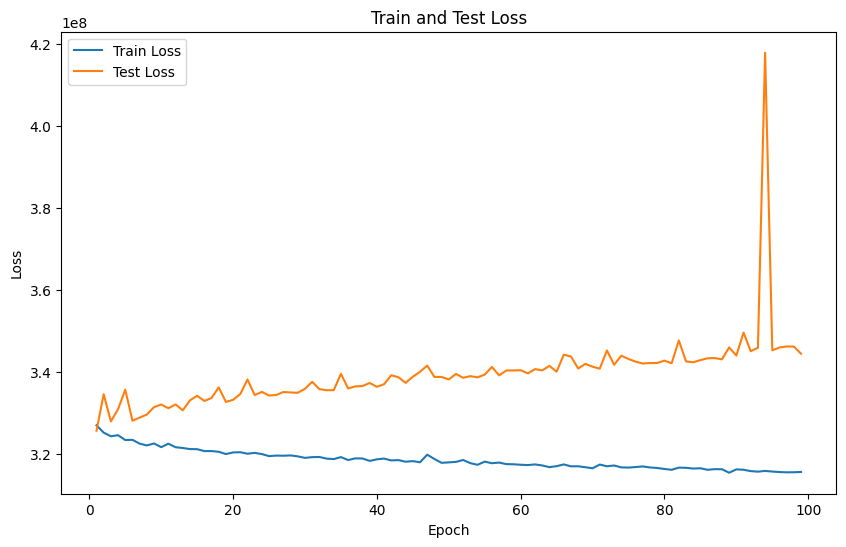

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
results_df = pd.read_csv(f"results/results_train_{TRAIN_NO}.csv")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(results_df["epoch_no"], results_df["train_loss"], label="Train Loss")
plt.plot(results_df["epoch_no"], results_df["test_loss"], label="Test Loss")

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss")

# Add legend
plt.legend()

# Display the plot
plt.show()


Validation: 14it [00:00, 27.24it/s]


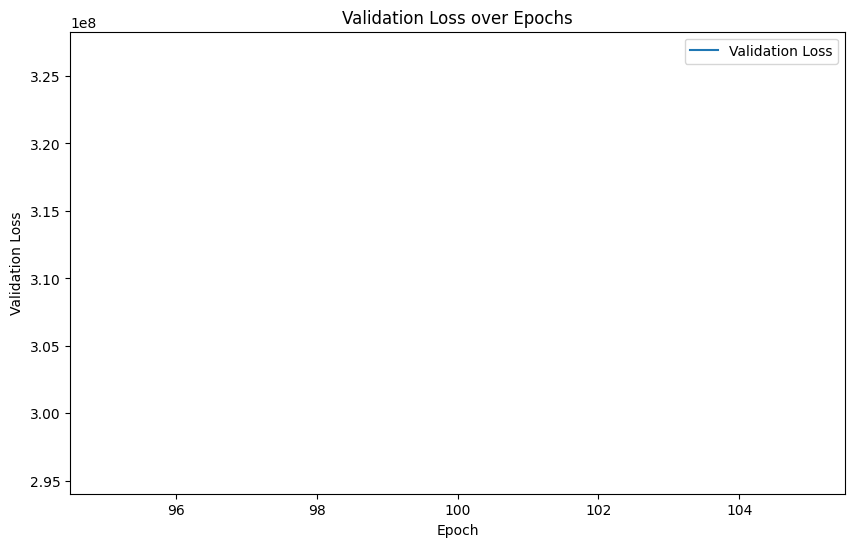

In [18]:
# prompt: call validation for each recorded epoch and plot all validation losses

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
def validate(model, criterion, val_loader):
  """Performs validation on the model."""
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for batch_idx, input_images in tqdm(enumerate(val_loader), desc="Validation"):
      input_images = input_images.type(torch.float)
      input_images = input_images.to(device)
      outputs, mu, logvar = model(input_images)
      loss = criterion(outputs, input_images, mu, logvar)
      val_loss += loss.item()
  return val_loss / len(val_loader)

# Loop through each epoch's checkpoint
epoch_validation_losses = []
for epoch in range(1, EPOCHS + 1):
  if os.path.exists(f'checkpoints/vae_model_train_{TRAIN_NO}_epoch_{epoch}.pth'):
      model.load_state_dict(torch.load(f'checkpoints/vae_model_train_{TRAIN_NO}_epoch_{epoch}.pth', weights_only=False))
      model = model.to(device)
      val_loss = validate(model, criterion, val_loader)
      epoch_validation_losses.append({'epoch': epoch, 'val_loss': val_loss})

# Convert to DataFrame for easier plotting
validation_df = pd.DataFrame(epoch_validation_losses)

# Plot the validation losses
plt.figure(figsize=(10, 6))
plt.plot(validation_df['epoch'], validation_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()


In [19]:
def compress(image):
  image = image.to(device).type(torch.float)
  image = image.unsqueeze(0)
  model.eval()
  with torch.no_grad():
    m, l = model.encode(image)
    z = model.reparameterize(m, l)

  z = z.cpu()
  z = z.squeeze(0)
  return z

def decompress(z):
  z = z.to(device).type(torch.float)
  z = z.unsqueeze(0)
  model.eval()
  with torch.no_grad():
    image = model.decode(z)

  image = image.cpu()
  image = image.type(torch.int)
  image = image.squeeze(0)
  return image




In [20]:
model.load_state_dict(torch.load(f'checkpoints/vae_model_train_{TRAIN_NO}_epoch_{EPOCHS}.pth', weights_only=False))
model = model.to(device)

In [21]:
# prompt: read 10 images from val_dataset and run them through the model and display the output using matplotlib

import matplotlib.pyplot as plt

# Select 10 images from the val_dataset
images_to_display = [val_dataset[i] for i in range(60,70)]

input_images = torch.stack(images_to_display)
input_images = input_images.type(torch.float)
input_images = input_images.to(device)

# Run the images through the model
model.eval()
with torch.no_grad():
  outputs, mu, logvar = model(input_images)



In [22]:
outputs = outputs.type(torch.int)
input_images = input_images.type(torch.int)

input_images = input_images.cpu()
outputs = outputs.cpu()

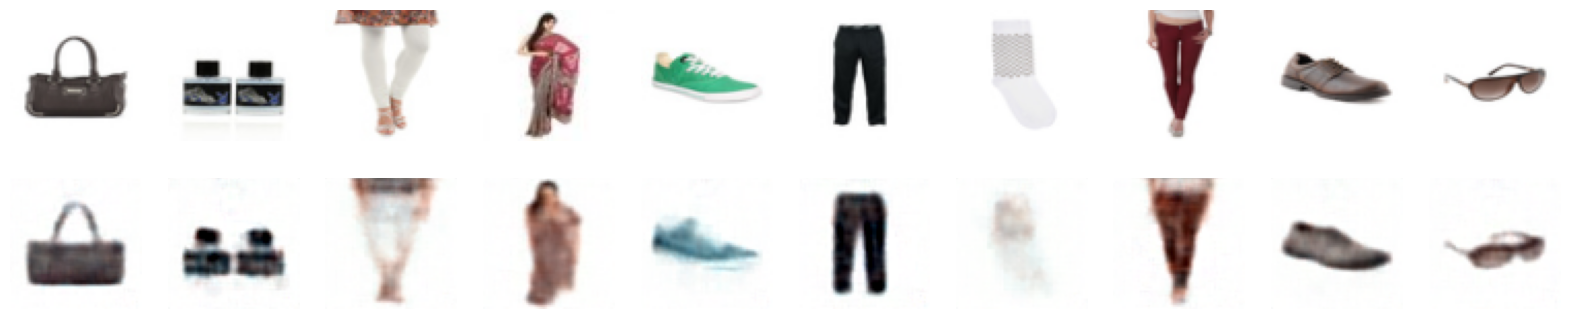

In [23]:

# Display the original and reconstructed images
fig, axes = plt.subplots(2,10, figsize=(20, 4))

for i in range(10):
  axes[0,i].imshow(input_images[i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(outputs[i].permute(1, 2, 0))
  axes[1,i].axis('off')

plt.show()

In [24]:
# prompt: compress checkpoints folder and results folder to zip file and save it

import shutil
import zipfile

def zip_folder(folder_path, output_path):
  """Zips a folder and its contents."""
  with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Zip the checkpoints folder
zip_folder('checkpoints', 'checkpoints.zip')

# Zip the results folder
zip_folder('results', 'results.zip')

print("Checkpoints and results folders zipped successfully.")


Checkpoints and results folders zipped successfully.


In [ ]:
!ls checkpoints | grep "train_28"